In [1]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from pandas.api.types import CategoricalDtype
from scipy import stats

## Data loading

In [3]:
date_parser = lambda x: pd.to_datetime(x, format = '%Y-%m-%d %H:%M:%S', exact=False, errors='coerce')
data = pd.read_csv('20200224_data_exploration_set.csv.gz', true_values=['t'], false_values=['f'],
                   dtype={'id': np.str, 'number': np.str, 'point_of_service_id': np.str, 'courier_id': np.str, 'courier_company_id': np.str, 
                          'recipient_customer_data_id': np.str, 'returning_point_of_service_id': np.str, 'sender_customer_data': np.str, 
                          'pos_dispatch_note_id': np.str, 'delivery_data_id': np.str, 'posting_data_id': np.str, 'child_document': np.str,
                          'last_dispatched_from_point_of_service_id': np.str, 'last_picked_up_from_point_of_service_id': np.str, 
                          'parcel_id': np.str, 'id.1': np.str, 'courier_company_id.1': np.str, 'courier_id.1': np.str, 
                          'recipient_customer_data_id.1': np.str, 'sender_customer_data_id.1': np.str, 'delivery_data_id.1': np.str,
                          }, 
                   parse_dates=['date_created', 'admission_date', 'max_pickup_date', 'ready_for_pickup_date', 'price_calculation_date', 
                                'delivery_date', 'pickup_date', 'registered_in_transit_date', 'dispatch_note_created_date', 'announcement_date', 
                                'ready_to_return_date', 'courier_updated_on', 'max_pickup_date.1'], 
                   date_parser=date_parser
               )

# not even a single value is filled
data = data.drop(columns=['insurance_option', 'size', 'returning_point_of_service_id', 'sender_customer_data_id', 'delivery_data_id', 
                          'courier_conditional_admission', 'posting_data_id', 'pickup_customer_data_id', 'returning_point_of_service_id.1', 
                          'posting_data_id.1',  'estimated_point_delivery_date', 'courier_point_delivery_date', 'price_calculation_date.1', 
                          'insurance_amount'])

data.columns = data.columns.str.replace('.1', '_row')

# make size categorical and ordered
parcel_size_cat = CategoricalDtype(categories=["A", "B", "C"], ordered=True)
data['size_row'] = data['size_row'].astype(parcel_size_cat)

# last row is some metadata, we may safely ignore it
data = data[:-1]

/home/szymon/anaconda3/envs/ml-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8,10,13,32,34,39,40,41,75,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
data.shape

(1810405, 65)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1810406 entries, 0 to 1810405
Data columns (total 65 columns):
 #   Column                                    Dtype              
---  ------                                    -----              
 0   class                                     object             
 1   id                                        object             
 2   date_created                              datetime64[ns, UTC]
 3   number                                    object             
 4   state                                     object             
 5   admission_date                            datetime64[ns, UTC]
 6   max_pickup_date                           datetime64[ns]     
 7   ready_for_pickup_date                     datetime64[ns, UTC]
 8   price_list                                object             
 9   price_calculation_date                    datetime64[ns, UTC]
 10  cash_on_delivery                          object             
 11  cash_on_del

In [6]:
data.head()

,class,id,date_created,number,state,admission_date,max_pickup_date,ready_for_pickup_date,price_list,price_calculation_date,...,max_pickup_date_row,charge_for_pickup,update_source,update_state,size_row,pickup_code_input_method,origin_row,force_online_payment_row,attention_fragile_row,non_standard_size_row
0,IncomingParcelInitialization,59818192,2019-09-02 02:05:05.471000+00:00,0000000059575318,CONFIRMED,NaT,NaT,NaT,NaN,NaT,...,NaT,NOTIFICATOR,NaN,NaN,B,NaN,NaN,False,False,False
1,ParcelAnnouncement,59818193,2019-09-02 02:05:05.785000+00:00,0000000059575319,CONFIRMED,NaT,NaT,NaT,NaN,NaT,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2,IncomingParcelInitialization,59818194,2019-09-02 02:55:03.316000+00:00,0000000059575320,CONFIRMED,NaT,NaT,NaT,NaN,NaT,...,NaT,NOTIFICATOR,NaN,NaN,B,NaN,NaN,False,False,False
3,ParcelAnnouncement,59818195,2019-09-02 02:55:03.331000+00:00,0000000059575321,CONFIRMED,NaT,NaT,NaT,NaN,NaT,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
4,IncomingParcelInitialization,59818196,2019-09-02 02:55:03.536000+00:00,0000000059575322,CONFIRMED,NaT,NaT,NaT,NaN,NaT,...,NaT,NOTIFICATOR,NaN,NaN,B,NaN,NaN,False,False,False


In [7]:
min(data['date_created'])

Timestamp('2019-09-02 02:05:05.471000+0000', tz='UTC')

In [8]:
max(data['date_created'])

Timestamp('2019-09-08 23:51:03.571000+0000', tz='UTC')

### Number of actions per hour and day

In [33]:
data = data.assign(weekday_created=data['date_created'].dt.day_name(), hour_created=data['date_created'].dt.hour)
weekday_cat = CategoricalDtype(categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
data['weekday_created'] = data['weekday_created'].astype(weekday_cat)

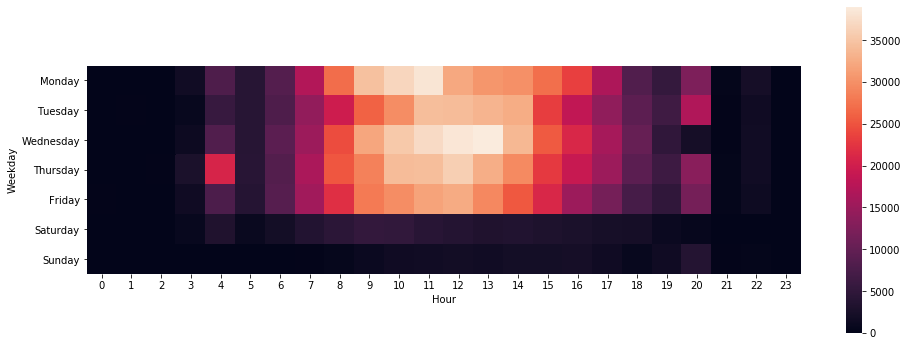

In [40]:
plt.figure(figsize=(16, 6))
sns.heatmap(pd.crosstab(data['weekday_created'], data['hour_created']), square=True)
plt.xlabel('Hour')
plt.ylabel('Weekday')
plt.show()

# Let's crunch some numbers

## Parcel value

In [ ]:
plt.figure(figsize=(10, 8))
sns.catplot(y='parcel_value', x='size_row', data=data)
plt.title("Parcel values' distribution with respect to the size of the parcel")
plt.xlabel('Parcel size')
plt.ylabel('Parcel value')
plt.show()

Is there statistical difference of the parcel value with respect to its size?

In [ ]:
# H0 of Kruskal test - medians of the groups are equal
for size_1, size_2 in itertools.combinations(data['size_row'].dropna().unique().to_list(), 2):
    first_group = data.loc[(~data['parcel_value'].isna()) & (data['size_row']==size_1)]['parcel_value']
    second_group = data.loc[(~data['parcel_value'].isna()) & (data['size_row']==size_2)]['parcel_value']
    _, p_val = stats.kruskal(first_group, second_group)
    print(f'p-value for the test between parcel size {size_1} (median: {first_group.median()}) and {size_2} (median: {second_group.median()}): {p_val:.4f}')

In [ ]:
data_with_parcel_value_provided = data.loc[data['parcel_id'].isin(data.loc[~data['parcel_value'].isna()]['parcel_id'])]

In [ ]:
def extract_dates(df, class_1, class_2, date_column, index_column, additional_columns = [], add_date_difference=True, check_state=True):
    """class_2 should be the class that follows class_1 in the workflow!"""
    cols = ['class', date_column, index_column]
    if check_state:
        cols.extend(['state'])
    if additional_columns:
        cols.extend(additional_columns)
    df = df[cols]
    # class_1
    cl_1 = df.loc[df['class']==class_1]
    cl_1 = cl_1.set_index(index_column)
    print(f'{cl_1.shape[0]} entries found with class {class_1}.')
    if check_state:
        not_confirmed = (cl_1['state']!='CONFIRMED').sum()
        if not not_confirmed == 0:
            warnings.warn(f'There are {not_confirmed} parcels whose state is not "CONFIRMED".')
        cl_1 = cl_1.drop(columns=['state'])

    cl_2 = df.loc[df['class']==class_2]
    cl_2 = cl_2.set_index(index_column)
    print(f'{cl_2.shape[0]} entries found with class {class_2}.')
    if check_state:
        not_confirmed = (cl_2['state']!='CONFIRMED').sum()
        if not not_confirmed == 0:
            warnings.warn(f'There are {not_confirmed} parcels whose state is not "CONFIRMED".')
        cl_2 = cl_2.drop(columns=['state'])

    ret = cl_1.merge(cl_2, left_index=True, right_index=True)
    ret = ret.assign(date_diff = ret[date_column + '_y'] - ret[date_column + '_x'])
    ret['date_diff'] = ret['date_diff'].apply(lambda x: x.total_seconds()/3600)  # difference in hours
    return ret

In [ ]:
df_1 = extract_dates(data_with_parcel_value_provided, 'CustomerParcelPickup', 'CustomerParcelPickupConfirmation', 'date_created', 'parcel_id', check_state=False)

In [ ]:
df_1 = df_1.merge(data.loc[(~data['parcel_value'].isna()) & (data['parcel_id'].isin(df_1.index))][['parcel_value', 'parcel_id']].set_index('parcel_id'),
                  left_index=True, right_index=True)

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='parcel_value', y='date_diff', data=df_1, s=100)
plt.xlabel('Parcel value')
plt.ylabel('Package waiting for pickup (h)')
plt.show()

So few parcels...

In [ ]:
def get_state_diagram(df, date_column, skip_optional_states=False):
    OPTIONAL_STATES = ['OrderDocument', 'ApplyRebate', 'ParcelInTransitDocument', 'IncomingParcelInitialization']
    df = df.sort_values(date_column)
    states = df['class'].values
    if skip_optional_states:
        states = states[np.logical_not(np.in1d(states, OPTIONAL_STATES, ))]
    ret = ' --> '.join(states)
    return ret

In [ ]:
n = 19
get_state_diagram(data.loc[data['parcel_id'].isin(data.loc[~data['parcel_value'].isna()]['parcel_id'].iloc[n:(n+1)])], 'date_created', skip_optional_states=True)

In [ ]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

In [ ]:
init_notebook_mode(connected=True)

In [ ]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

In [ ]:
flows = dict()
all_states = dict()
all_states_set = set()

for parcel_id, df in data_with_parcel_value_provided.groupby(['parcel_id']):
    df = df.sort_values('date_created')
    for a_pair in pairwise(df['class']):
        if a_pair in flows:
            flows[a_pair] += 1
        else:
            flows[a_pair] = 1
        if not a_pair[0] in all_states_set:
            all_states_set.add(a_pair[0])
            if not all_states:
                all_states[a_pair[0]] = 0
            else:
                all_states[a_pair[0]] = max(all_states.values()) + 1
        if not a_pair[1] in all_states_set:
            all_states_set.add(a_pair[1])
            all_states[a_pair[1]] = max(all_states.values()) + 1

In order to run the diagram below, it may be necessary to activate jupyter extensions for jupyter lab:

jupyter labextension install jupyterlab-plotly

jupyter lab build

In [ ]:
fig = go.Figure(data=[go.Sankey(
    # Define nodes
    orientation = "v",
    valueformat = ".0f",
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label = [k for k, v in sorted(all_states.items(), key=lambda item: item[1])],
      color = "blue"
    ),
    # Add links
    link = dict(
      source = [all_states[item[0]] for item in flows.keys()],
      target = [all_states[item[1]] for item in flows.keys()],
      value = list(flows.values()),
    )
)])

layout =  dict(
    title = "Changes of states for the packages for whose the price was provided.",
    height = 772,
    width = 950,
    font = dict(
      size = 10
    ),    
)
fig.layout = layout
fig.show()

## Points of service vs couriers

In [79]:
couriers_vs_pos = data.loc[~data['courier_id'].isna()][['number', 'courier_id', 'point_of_service_id']].\
    drop_duplicates().drop(columns=['number'])

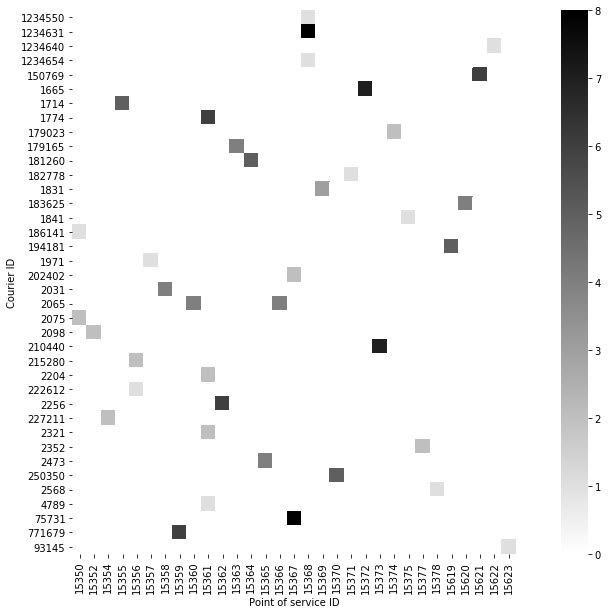

In [81]:
plt.figure(figsize=(16, 10))
sns.heatmap(pd.crosstab(couriers_vs_pos['courier_id'], couriers_vs_pos['point_of_service_id']), 
            square=True, cmap='gray_r')
plt.xlabel('Point of service ID')
plt.ylabel('Courier ID')
plt.show()

In [33]:
data.loc[~data['point_of_service_id'].isna()]['parcel_id']

35         9050417
909        9179445
910        9177725
911        9135489
912        9164754
            ...   
1810227    9136868
1810228    9100870
1810229    9100870
1810230    9162394
1810231    9162394
Name: parcel_id, Length: 731727, dtype: object

In [29]:
data['point_of_service_id'].value_counts()

9130     622
15010    588
2402     535
13020    533
14633    525
        ... 
13005      1
8187       1
14366      1
5244       1
7437       1
Name: point_of_service_id, Length: 5686, dtype: int64